<center><h1>Exploring Training Data</h1></center>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, accuracy_score
from sklearn.svm import SVC
from scipy import stats
import math
from tqdm import tqdm_notebook
import re
from helpers import preprocessing, TemporalSegments, my_pipeline, time_invariant_features, effort_features, temporal_features, temporal_summary_features
from helpers import temporal_feature_name
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
# load data
assessments = pd.read_csv('../Data/Raw/assessments.csv') # pk = code_module, code_presentation, id_assessment
courses = pd.read_csv('../Data/Raw/courses.csv') # pk = code_module, code_presentation
studentAssessment = pd.read_csv('../Data/Raw/studentAssessment.csv') # pk = id_assessment(this is unique across course sessions), id_student
studentInfo = pd.read_csv('../Data/Raw/studentInfo.csv') # pk = code_module, code_presentation, id_student
studentRegistration = pd.read_csv('../Data/Raw/studentRegistration.csv') #pk = code_module, code_presentation, id_student
vle = pd.read_csv('../Data/Raw/vle.csv') # pk = id_site
studentVle = pd.read_csv('../Data/Raw/studentVle.csv') # pk = code_module, code_presentation, id_student, id_site

## 1. Training-testing split

In [3]:
studentInfo['code_presentation'].value_counts() / studentInfo['code_presentation'].value_counts().sum()

2014J    0.345473
2013J    0.271377
2014B    0.239438
2013B    0.143712
Name: code_presentation, dtype: float64

the conventional training-testing split will take the 0.8:0.2 split.    
However, as we observe data in a **term by term manner**(or presentation by presentation for the Open University), it makes more sense to split the training and testing based on time

---
**Note:** it is a good practice to seperate the data at the very begining to avoid *peaking into the testing set*

In [5]:
def train_test_split(df):
    '''this function mimic the train_test_split in sklearn.model_selection.train_test_split; However, it does not split X and y yet'''
    training_presentation = ['2013B', '2013J', '2014B']
    testing_presentation = ['2014J']
    training_assessments = assessments[assessments['code_presentation'].\
        isin(training_presentation)]['id_assessment'].tolist()
    testing_assessments = assessments[~assessments['code_presentation'].\
        isin(training_presentation)]['id_assessment'].tolist()
    if 'code_presentation' in df.columns:
        train = df[df['code_presentation'].isin(training_presentation)]
        test = df[df['code_presentation'].isin(testing_presentation)]
    elif 'id_assessment' in df.columns:
        train = df[df['id_assessment'].isin(training_assessments)]
        test = df[df['id_assessment'].isin(testing_assessments)]
    else:
        raise NotImplementedError
    
    return train, test 

In [8]:
class NameSpace(object):
    pass

train = NameSpace()
test = NameSpace()
total = NameSpace()
datasets = [assessments, courses, studentAssessment, studentInfo, 
            studentRegistration, vle, studentVle]
data_names = ['assessments', 'courses', 'studentAssessment', 'studentInfo',
             'studentRegistration', 'vle', 'studentVle']
for pt in range(len(datasets)):
    name = data_names[pt]
    df = datasets[pt]
    df_train, df_test = train_test_split(df)
    setattr(train, name, df_train)
    setattr(test, name, df_test)
    setattr(total, name, df)

simple validation

In [9]:
for pt in range(len(datasets)):
    df = datasets[pt]
    name = data_names[pt]
    assert getattr(train, name).shape[0] + getattr(test, name).shape[0] == df.shape[0], (
        'the size of {} in train and test do not add up to the original data'.format(name)) 
    print('everything looks good for {}!'.format(name))

everything looks good for assessments!
everything looks good for courses!
everything looks good for studentAssessment!
everything looks good for studentInfo!
everything looks good for studentRegistration!
everything looks good for vle!
everything looks good for studentVle!


## 2. Explore the training set

In [10]:
# check how many students withdrawed/failed/passed the courses
train.studentInfo['final_result'].value_counts() / \
    train.studentInfo['final_result'].value_counts().sum()

Pass           0.378193
Withdrawn      0.296723
Fail           0.237894
Distinction    0.087189
Name: final_result, dtype: float64

Both **Withdrawn** and **Fail** seems to be a serious problem for *The Open University*

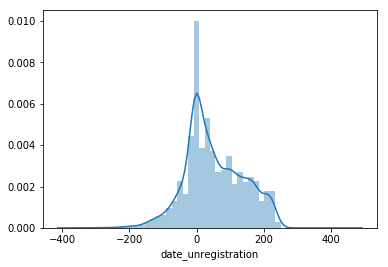

In [11]:
# check the withdrawn date 
studentWithdraw = train.studentRegistration[train.studentRegistration['date_unregistration'].notnull()]
sns.distplot(studentWithdraw['date_unregistration'])

quite a portion of students withdrawn before the start of the course. This might mean that they have checked the course material and think the course is not attractive or they are not well prepared. 

I believe withdrawn before the start date is a <font color='red'>zero</font> consequential action.   
And withdrawn **early** should be a <font color='red'>low</font> consequential action

In [12]:
# check if withdraw prior to class is also counted in the studentInfo
print('the number of withdrawn students in studentInfo is {}'.
      format((train.studentInfo['final_result'] == 'Withdrawn').sum()))
print('the number of withdrawn student in studentRegistration is {}'.
     format(studentWithdraw.shape[0]))

the number of withdrawn students in studentInfo is 6330
the number of withdrawn student in studentRegistration is 6333


In [13]:
# check the time of writhdrawing
print('the number of withdrawn before the start date is {}'.
     format((studentWithdraw['date_unregistration'] < 0).sum()))
print('the number of withdrawn on the start date is {}'.
     format((studentWithdraw['date_unregistration'] == 0).sum()))
print('the number of withdrawn before the first week is {}'.
     format(((studentWithdraw['date_unregistration'] > 0) & (studentWithdraw['date_unregistration'] < 7))
      .sum()))

the number of withdrawn before the start date is 1783
the number of withdrawn on the start date is 417
the number of withdrawn before the first week is 141


In [14]:
# adjust the number of withdrawn by only withdrawn that happen after course start
adjust = train.studentInfo['final_result'].value_counts()
adjust['Withdrawn'] -= 1783

print('excluding students that dropped before the start date: \n')
print(adjust / adjust.sum())

excluding students that dropped before the start date: 

Pass           0.412685
Withdrawn      0.232583
Fail           0.259591
Distinction    0.095141
Name: final_result, dtype: float64


In [15]:
# adjust the number of withdrawn by only withdrawn that happen after the fist week of course
adjust = train.studentInfo['final_result'].value_counts()
adjust['Withdrawn'] -= (studentWithdraw['date_unregistration'] < 7).sum()

print('excluding students that dropped before the 2nd week of class: \n')
print(adjust / adjust.sum())

excluding students that dropped before the 2nd week of class: 

Pass           0.424810
Withdrawn      0.210036
Fail           0.267218
Distinction    0.097936
Name: final_result, dtype: float64


---
**Conclusion**:
1. both Withdrawn and Fail are import problems for *the Open University*. Failing seems to be slightly more important
2. need to remove students that dropped before course start date in the begining of the pipeline (**if the research question is dropouts**)

---
**Question**:
Among the persisted students, can we build an early prediction system to predict individuals' Fail rate? Like, before the first assessment?

The most important features should be the students daily vle participatin

## 3. Exploring students daily VLE participation

Students VLE participation could be conceptually seperate into two dimentions:
1. effort
2. allocation of effort across time and resouces

a. Effort

In [232]:
# visuallize sum_click
click = train.studentVle.copy()
click = click.groupby(['code_module', 'code_presentation', 'id_student', 'date']
                     )['sum_click'].agg('sum')

In [233]:
click = click.unstack(-1).fillna(0).reset_index()

In [234]:
info = train.studentInfo[['code_module', 'code_presentation', 'id_student', 'final_result']].copy()

subject = info[['code_module', 'code_presentation', 'id_student']]
subject = subject[~subject.duplicated()]
subject['subject'] = range(subject.shape[0])

In [235]:
click = info.merge(click, on=['code_module', 'code_presentation', 'id_student'], how='inner')

In [236]:
click_pass = click[click['final_result']=='Pass'].iloc[:, 4:].sample(frac=0.1)
click_fail = click[click['final_result']=='Fail'].iloc[:, 4:].sample(frac=0.1)
click_withdrawn = click[click['final_result']=='Withdrawn'].iloc[:, 4:].sample(frac=0.1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


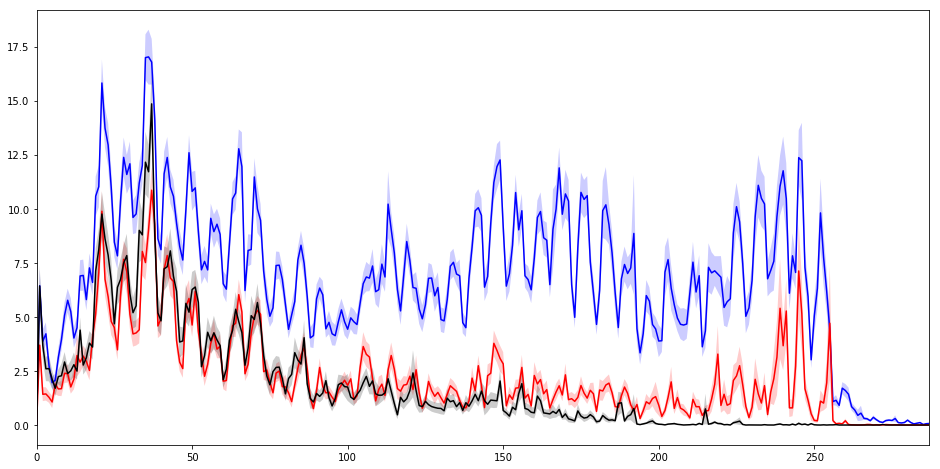

In [237]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
t1 = sns.tsplot(click_pass.values, ax=ax, color='blue')
t2 = sns.tsplot(click_fail.values, ax=ax, color= 'red')
t3 = sns.tsplot(click_withdrawn.values, ax=ax, color='black')

Joint Distribution of resource and 

In [129]:
click = train.studentVle.copy()
resource = train.vle.copy()
info = train.studentInfo[['code_module', 'code_presentation', 'id_student', 'final_result']].copy()

In [130]:
join = click.merge(resource, on=['code_module', 'code_presentation','id_site'], how='inner')
join = join.merge(info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

In [161]:
join_pass = join[join['final_result'] == 'Pass']
join_fail = join[join['final_result'] == 'Fail']

In [163]:
# this will return the join distribution of resource and time for sum_click
join_pass = join_pass.groupby(['activity_type', 'date'])['sum_click'].agg('mean')
join_fail = join_fail.groupby(['activity_type', 'date'])['sum_click'].agg('mean')

In [164]:
# normalize
join_pass = join_pass / join_pass.sum() #* 10000
join_fail = join_fail / join_fail.sum() #* 10000

In [165]:
join_pass = join_pass.unstack('date').fillna(0)
join_fail = join_fail.unstack('date').fillna(0)

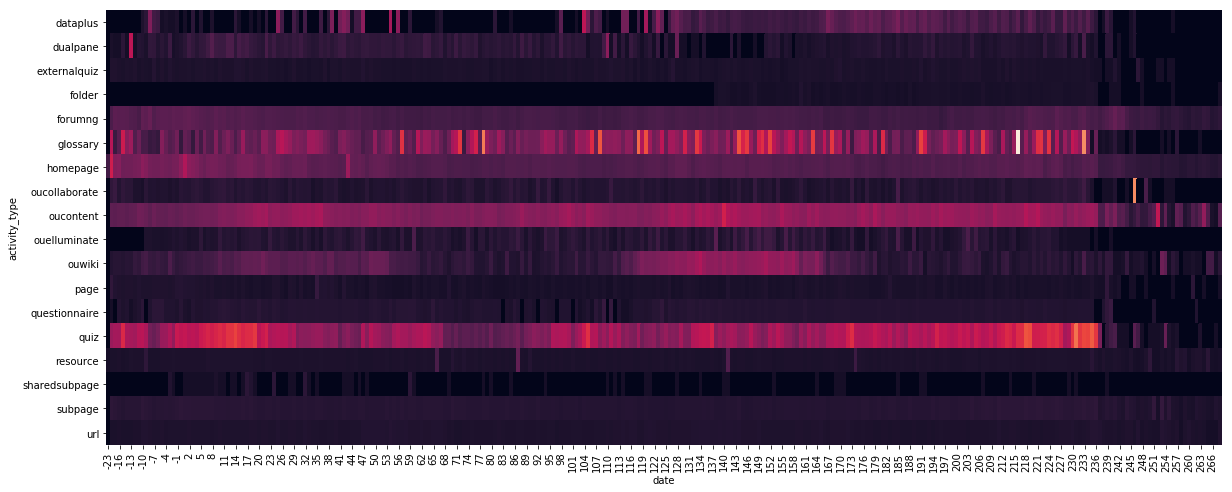

In [169]:
# transform to matrix
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
sns.heatmap(join_pass, ax=ax, cbar=False)

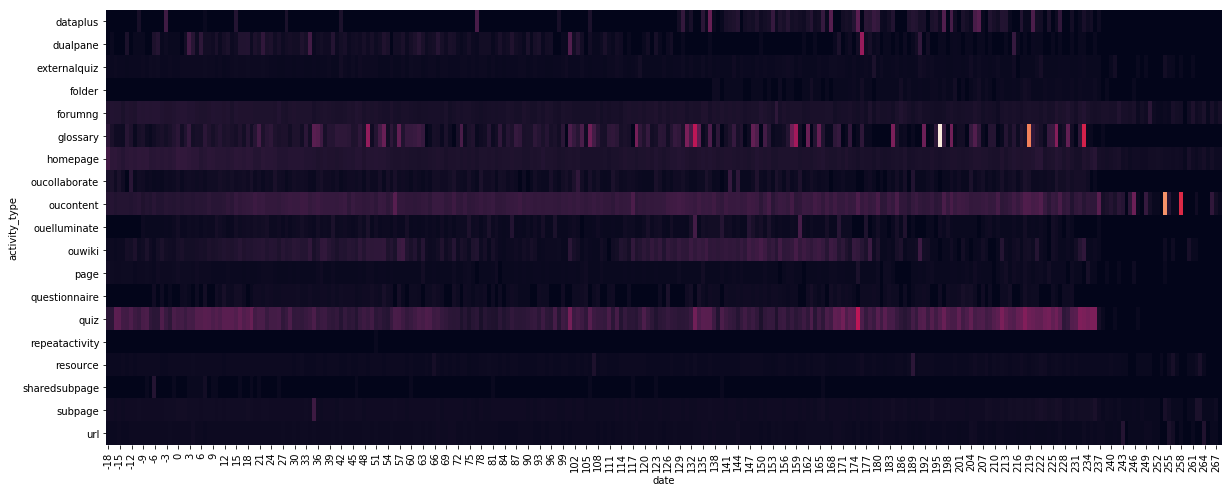

In [170]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
sns.heatmap(join_fail, ax=ax, cbar=False)

Very Interesting, the distribution for an average *passed students* seems to be much **spreadout** than the an average *failed students*

---
The single best indicator to describe this will be **Entropy**!

c. marginal distribution of effort on resource

In [176]:
sample = train.studentInfo[train.studentInfo['final_result']!='Withdrawn'][[
    'code_module', 'code_presentation', 'id_student']]
sample = sample.merge(train.studentVle, 
                      on=['code_module', 'code_presentation', 'id_student'], 
                      how='left')
sample = sample.merge(train.vle, 
                      on=['id_site', 'code_module', 'code_presentation'], 
                      how='left')

In [177]:
sample['temperal_seg'] = sample['date'].apply(lambda x: math.ceil(x / 30.) if pd.notnull(x) else x)

In [178]:
identifiers = ['code_module', 'code_presentation', 'id_student', 'temperal_seg']
X_effort = sample.groupby(identifiers)['sum_click'].agg('sum').reset_index()

In [179]:
X_strategy = sample.groupby(identifiers + ['activity_type'])['sum_click'].agg('sum').unstack(-1)
X_strategy = X_strategy.div(X_strategy.sum(axis=1), axis=0)
X_strategy.reset_index(inplace=True)
X_strategy.fillna(0, inplace=True)

In [180]:
pca = PCA(10)

In [181]:
pca.fit(X_strategy.iloc[:, 4:])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [182]:
pca.explained_variance_ratio_[:4].sum()

0.93204785344641528

Four principle components explained 93% of all variance

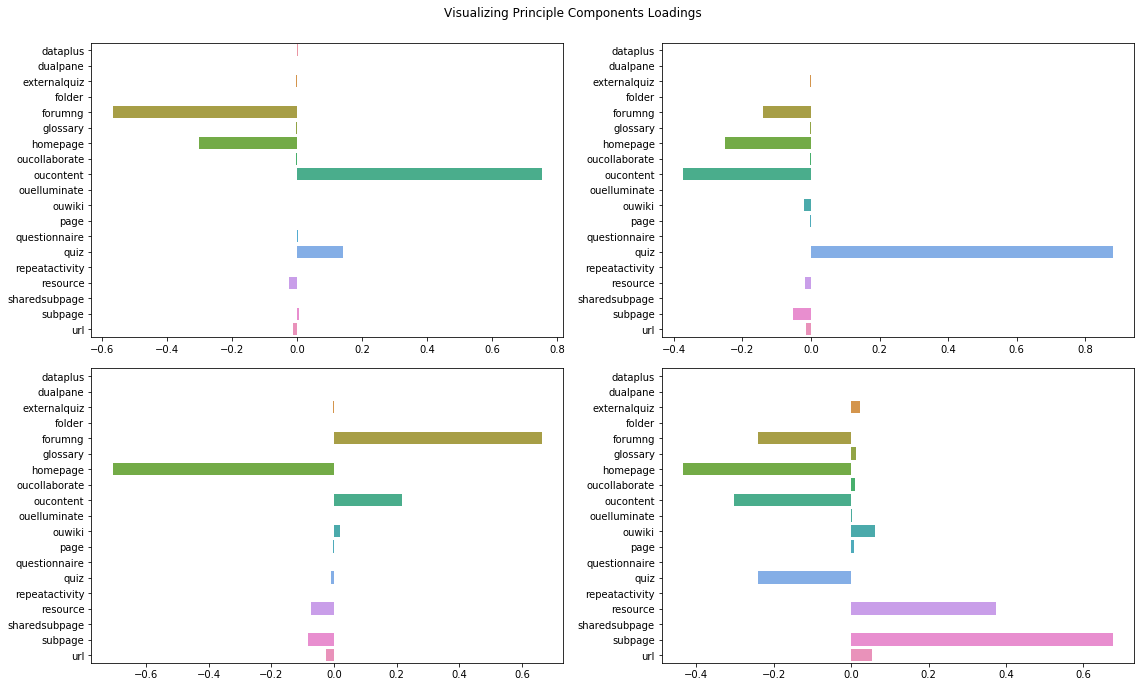

In [183]:
# visualize the principle components
fig = plt.figure(figsize=(16, 10))
component_pt = 0
for row in range(1, 3):
    for col in range(1, 3):
        ax = fig.add_subplot(2, 2, component_pt + 1)
        sns.barplot(y=X_strategy.columns[4:], x=pca.components_[component_pt], ax = ax)
        component_pt += 1
        ax.set_ylabel('')
        
fig.suptitle('Visualizing Principle Components Loadings')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Mariginal Distributin on Time

In [239]:
# visuallize sum_click
click = train.studentVle.copy()
click = click.groupby(['code_module', 'code_presentation', 'id_student', 'date']
                     )['sum_click'].agg('sum')

In [240]:
click = click.unstack(-1).fillna(0).reset_index()

In [241]:
info = train.studentInfo[['code_module', 'code_presentation', 'id_student', 'final_result']].copy()

In [242]:
click = info.merge(click, on=['code_module', 'code_presentation', 'id_student'], how='inner')

In [243]:
click_pass = click[click['final_result']=='Pass'].iloc[:, 4:].sample(frac=0.1)
click_fail = click[click['final_result']=='Fail'].iloc[:, 4:].sample(frac=0.1)
click_withdrawn = click[click['final_result']=='Withdrawn'].iloc[:, 4:].sample(frac=0.1)

In [244]:
period = list(range(30))
# look at the first 30 days
click_pass = click_pass[period] 
click_fail = click_fail[period]
click_withdrawn = click_withdrawn[period]

In [245]:
# normalize
click_pass = click_pass.div(click_pass.sum(axis=1), axis=0) * 100
click_fail = click_fail.div(click_fail.sum(axis=1), axis=0) * 100
click_withdrawn = click_withdrawn.div(click_withdrawn.sum(axis=1), axis=0) * 100

In [252]:
click_pass = click_pass.fillna(0)
click_fail = click_fail.fillna(0)
click_withdrawn = click_withdrawn.fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


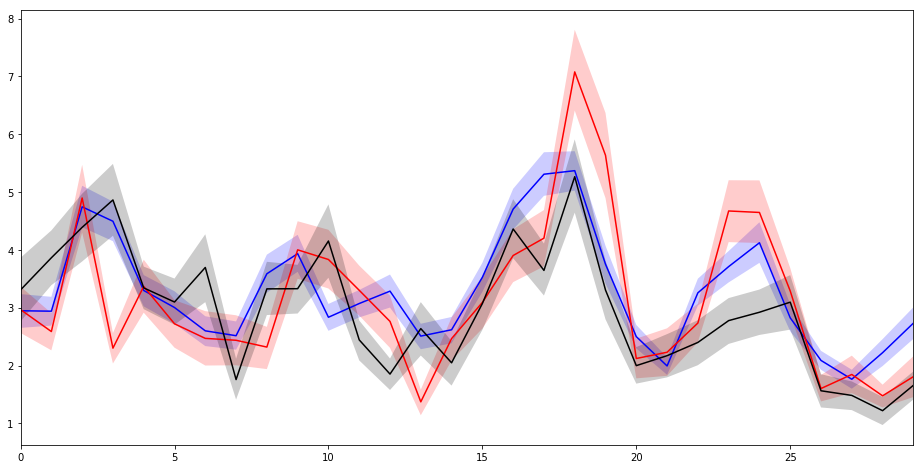

In [253]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
t1 = sns.tsplot(click_pass.values, ax=ax, color='blue')
t2 = sns.tsplot(click_fail.values, ax=ax, color= 'red')
t3 = sns.tsplot(click_withdrawn.values, ax=ax, color='black')

In [184]:
# build marginal distribution features
sample['temperal_seq'] = sample['date'] - (sample['temperal_seg'] - 1) * 30

In [185]:
# assuming every day people will have some activity
X_temporal = sample.groupby(identifiers + ['temperal_seq']
                           )['sum_click'].agg('sum').unstack(-1)

X_temporal.fillna(0, inplace=True)
X_temporal = X_temporal.div(X_temporal.sum(axis=1), axis=0)
X_temporal.reset_index(inplace=True)

In [187]:
seq = list(range(1, 31))
X_temporal['peak'] = X_temporal[seq].max(axis=1)
X_temporal['variation'] = X_temporal[seq].var(axis=1).apply(math.log)
X_temporal['kurtosis'] = X_temporal[seq].kurtosis(axis=1)
X_temporal['longest_zeros'] = X_temporal[seq].apply(lambda x: preprocessing.longest_run(x, 0), axis=1)
X_temporal['longest_ones'] = X_temporal[seq].apply(lambda x: preprocessing.longest_run(x, 1), axis=1)

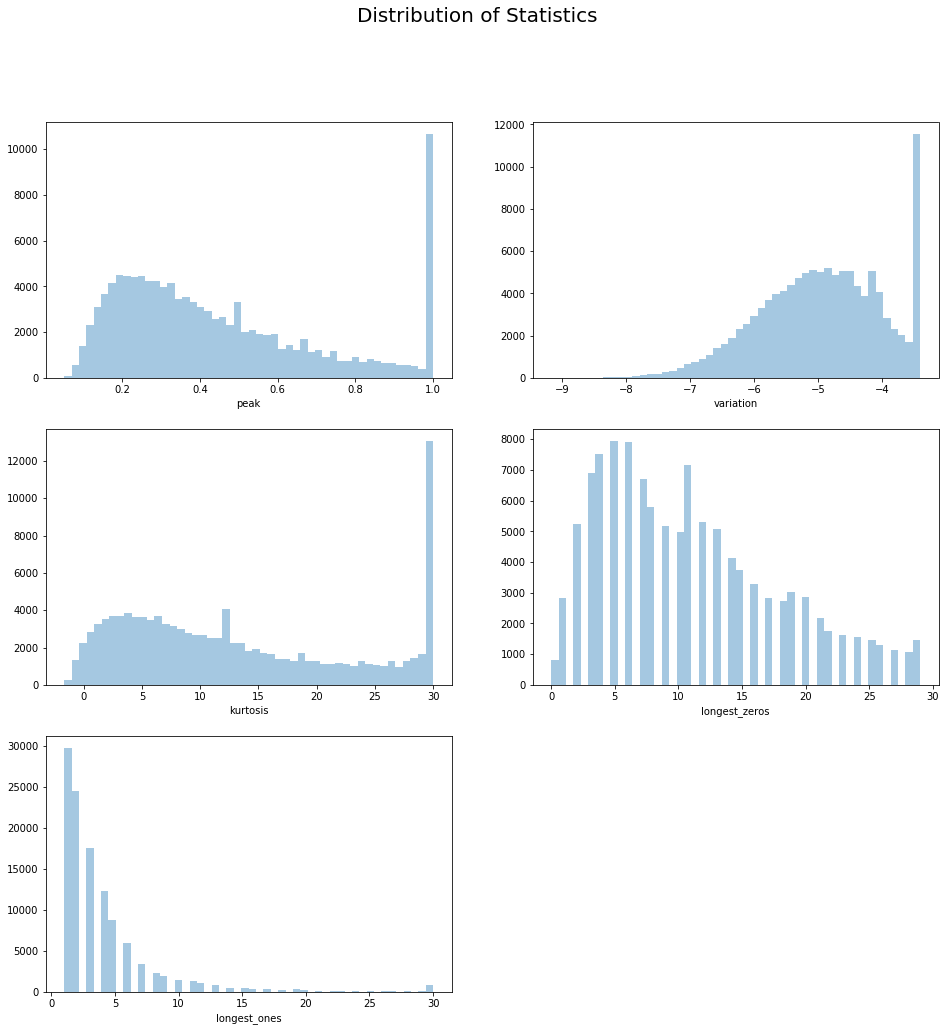

In [254]:
# plot the distributions
fig = plt.figure(figsize=(16, 16))
fig_pt = 1
for stat in ['peak', 'variation', 'kurtosis', 'longest_zeros', 'longest_ones']:
    ax = fig.add_subplot(3, 2, fig_pt)
    sns.distplot(X_temporal[stat], ax=ax, kde=False)
    ax.set_xlabel(stat)
    fig_pt += 1
plt
fig.suptitle('Distribution of Statistics', fontsize=20)